# T2A-LoRA

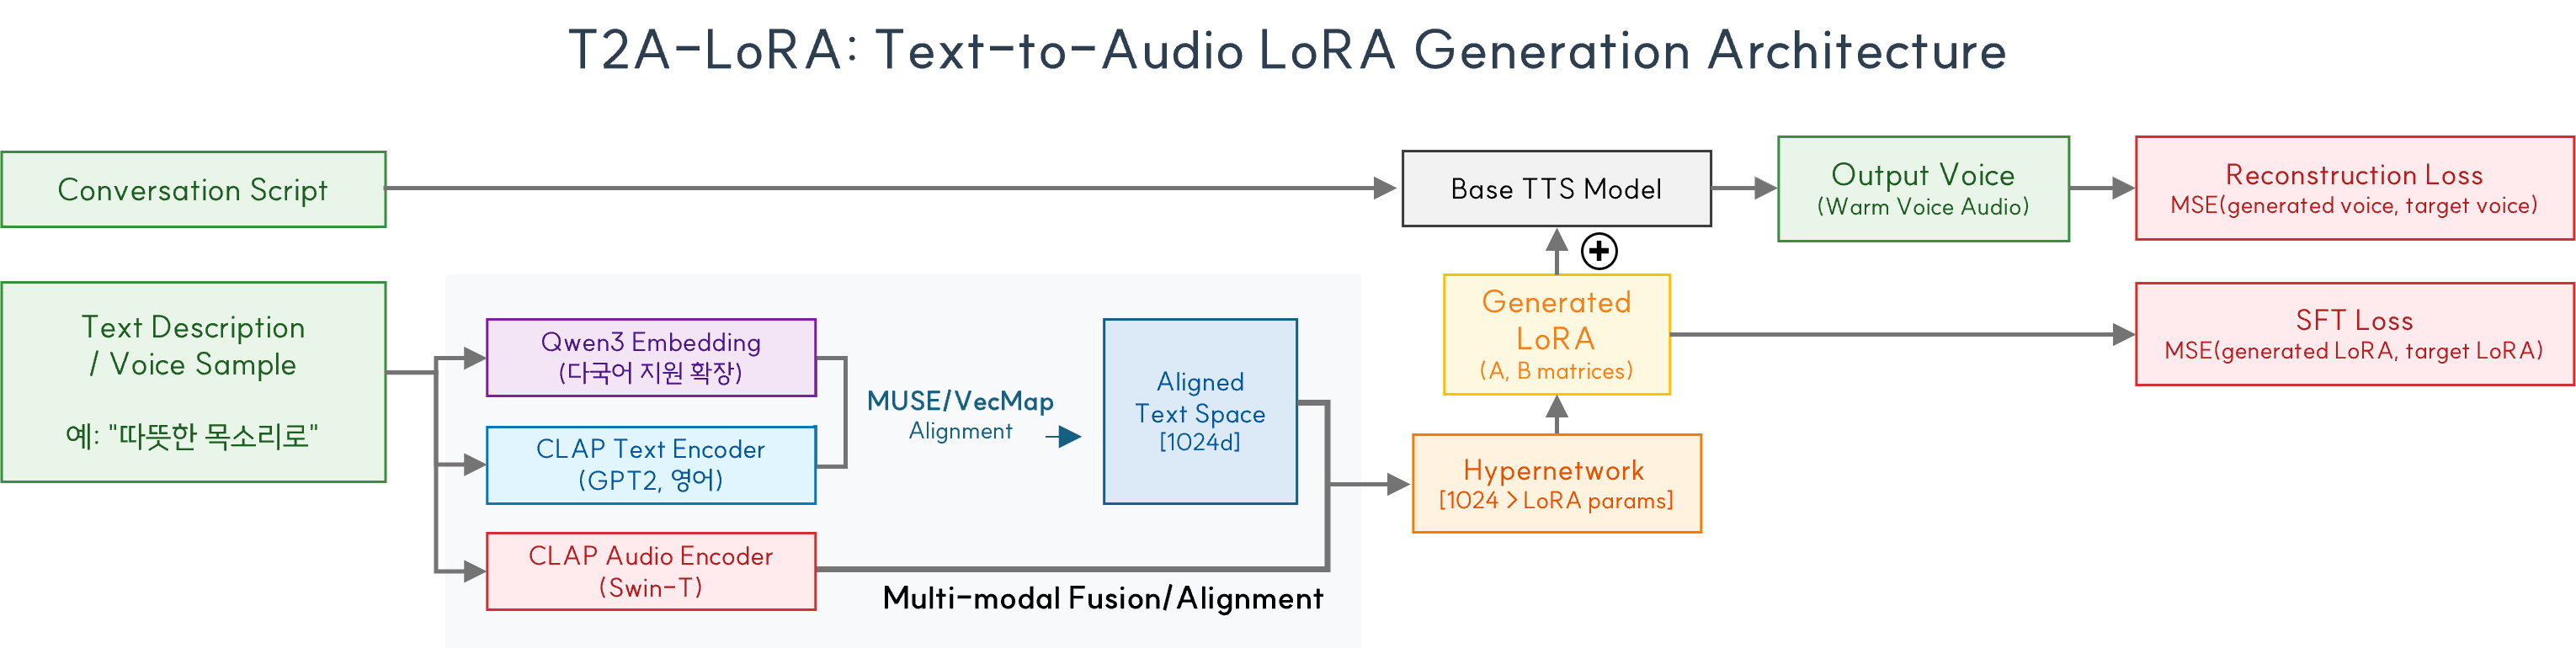

## Imports

In [ ]:
from transformers import DiaForConditionalGeneration, AutoProcessor
from transformers import Qwen3Model, AutoTokenizer
from transformers import ClapModel, ClapProcessor

from transformers import Trainer, TrainingArguments
from peft import LoraConfig, TaskType, get_peft_model

from datasets import load_dataset
import torchaudio
from torch import nn
import torch

import numpy as np

import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

### Check GPU Availability

In [ ]:
!nvidia-smi

In [ ]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 0
ADDITIONAL_GPU = 0

if torch.cuda.is_available():
    if ADDITIONAL_GPU:
        torch.cuda.set_device(DEVICE_NUM)
        device = torch.device("cuda")
    else:
        device = torch.device(f"cuda:{DEVICE_NUM}")
else:
    device = torch.device("cpu")
    DEVICE_NUM = -1

print(f"INFO: Using device - {device}" + (f":{DEVICE_NUM}" if ADDITIONAL_GPU else ""))

## Datasets

In [ ]:
def show_waveform(audio_path: str | None, waveform: torch.Tensor | None = None, sr: int = 48000):
    if audio_path:
        waveform, sr = torchaudio.load(audio_path)
    elif waveform is not None:
        waveform = waveform.unsqueeze(0) if len(waveform.shape) == 1 else waveform
    else:
        raise ValueError("Either audio_path or waveform must be provided.")

    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(waveform.numpy()[0], sr=sr)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

    return Audio(waveform.numpy()[0], rate=sr)

In [ ]:
main_dataset_url = "https://www.openslr.org/141/"
main_dataset_annotation_url = "https://raw.githubusercontent.com/line/LibriTTS-P/refs/heads/main/data/df3_en.csv"
sub_dataset_id = "parler-tts/libritts_r_tags_tagged_10k_generated"

In [ ]:
sub_dataset_clean = load_dataset(sub_dataset_id, "clean", features={'audio': "audio"})
#sub_dataset_other = load_dataset(sub_dataset_id, "other", features={'audio': "audio"})  # big dataset

In [ ]:
sub_dataset_clean.keys()

In [ ]:
len(sub_dataset_clean['train.clean.100'])

In [ ]:
temporal_train_dataset = sub_dataset_clean['train.clean.100']

In [ ]:
temporal_train_dataset[0]

In [ ]:
sample_waveform, sample_sr = torchaudio.load(temporal_train_dataset[0]['path'].replace("/root/", "~/"))

In [ ]:
show_waveform(None, sample_waveform.numpy()[0], rate=sample_sr)

## Models

In [ ]:
base_model_id = "nari-labs/Dia-1.6B-0626"
qwen3_model_id = "Qwen/Qwen3-Embedding-0.6B"
clap_model_id = "laion/larger_clap_general"  # "microsoft/msclap"

In [ ]:
base_processor = AutoProcessor.from_pretrained(base_model_id)
qwen3_tokenizer = AutoTokenizer.from_pretrained(qwen3_model_id)
clap_processor = ClapProcessor.from_pretrained(clap_model_id)

In [ ]:
# Check base model architecture
base_model = DiaForConditionalGeneration.from_pretrained(base_model_id)
base_model.bfloat16()

In [ ]:
# Check qwen3 model architecture
qwen3_model = Qwen3Model.from_pretrained(qwen3_model_id)
qwen3_model.bfloat16()

In [ ]:
# Check clap model architecture
clap_model = ClapModel.from_pretrained(clap_model_id)
clap_model.bfloat16()

In [ ]:
clap_model.audio_model

In [ ]:
clap_model.text_model

### Model Tests

In [ ]:
test_text = [
    "[S1] Dia is an open weights text to dialogue model."
    "[S2] You get full control over scripts and voices."
    "[S1] Wow. Amazing. (laughs)"
    "[S2] Try it now on Git hub or Hugging Face."
]

### Dia 모델 생성 음성 일관성 테스트

In [ ]:
def generate_voice(filename, max_new_tokens=3072, guidance_scale=3.0, temperature=1.8, top_p=0.90, top_k=45):
    inputs = base_processor(text=test_text, padding=True, return_tensors="pt").to(device)

    base_model.to(device)
    outputs = base_model.generate(
        **inputs, max_new_tokens=max_new_tokens,
        guidance_scale=guidance_scale, temperature=temperature, top_p=top_p, top_k=top_k
    )

    outputs = base_processor.batch_decode(outputs)
    base_processor.save_audio(outputs, filename)

In [ ]:
# Normal settings
generate_voice("normal_settings1.mp3")
generate_voice("normal_settings2.mp3")

# Replicable settings
generate_voice("replicable_settings1.mp3", guidance_scale=4.0, temperature=0.1)
generate_voice("replicable_settings2.mp3", guidance_scale=4.0, temperature=0.1)

In [ ]:

generate_voice("replicable_settings1.mp3", guidance_scale=4.0, temperature=0.1)
generate_voice("replicable_settings2.mp3", guidance_scale=4.0, temperature=0.1)

In [ ]:
show_waveform("normal_settings1.mp3")

In [ ]:
show_waveform("normal_settings2.mp3")

In [ ]:
show_waveform("replicable_settings1.mp3")

In [ ]:
show_waveform("replicable_settings2.mp3")

### CLAP 모델 생성 임베딩 연관성 테스트

In [ ]:
text = ["a dog barking", "music playing"]
text_inputs = clap_processor(text=text, return_tensors="pt", padding=True)
audio_inputs = clap_processor(audios=sample_waveform, sampling_rate=sample_sr, return_tensors="pt")

with torch.no_grad():
    text_embeddings = clap_model.get_text_features(**text_inputs)
    audio_embeddings = clap_model.get_audio_features(**audio_inputs)

    similarity = (100.0 * text_embeddings @ audio_embeddings.T).softmax(dim=-1)
    print(similarity)

In [ ]:
new_text = "[S1] Hello, how are you? [S2] I'm good, thank you. [S1] What's your name? [S2] My name is Dia. [S1] Nice to meet you. [S2] Nice to meet you too."

# It will only return the audio from the text_to_generate
output = base_model.generate(
    test_text + new_text,
    audio_prompt="normal_settings1.mp3",
    use_torch_compile=False,
    verbose=True,
    cfg_scale=4.0,
    temperature=1.8,
    top_p=0.90,
    cfg_filter_top_k=50,
)

base_model.save_audio("normal_settings1-clone.mp3", output)

In [ ]:
audio_inputs1 = clap_processor(audios="normal_settings1.mp3", sampling_rate=sample_sr, return_tensors="pt")
audio_inputs2 = clap_processor(audios="normal_settings1-clone.mp3", sampling_rate=sample_sr, return_tensors="pt")
audio_others = clap_processor(audios="normal_settings2.mp3", sampling_rate=sample_sr, return_tensors="pt")

with torch.no_grad():
    audio1_embeddings = clap_model.get_text_features(**audio_inputs1)
    audio2_embeddings = clap_model.get_audio_features(**audio_inputs2)
    others_embeddings = clap_model.get_audio_features(**audio_others)

    similarity = (100.0 * audio1_embeddings @ audio2_embeddings.T).softmax(dim=-1)
    print("Reconstructed:", similarity)
    similarity = (100.0 * others_embeddings @ audio2_embeddings.T).softmax(dim=-1)
    print("Differ by:", similarity)

## LoRA

In [ ]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,  # sequence-to-sequence
    inference_mode=False,
    r=16,  # rank
    lora_alpha=32,  # scaling factor
    lora_dropout=0.1,

    target_modules=[
        # Decoder 부분 (Audio)
        "decoder.layers.*.self_attn.q_proj",
        "decoder.layers.*.self_attn.k_proj",
        "decoder.layers.*.self_attn.v_proj",
        "decoder.layers.*.self_attn.out_proj",

        # Cross-attention (Text-to-Audio)
        "decoder.layers.*.cross_attn.q_proj",
        "decoder.layers.*.cross_attn.k_proj",
        "decoder.layers.*.cross_attn.v_proj",
        "decoder.layers.*.cross_attn.out_proj",
    ],

    bias="none",
    modules_to_save=["lm_head"],
)

In [ ]:
model = get_peft_model(base_model, lora_config)
model.bfloat16()

## Hypernetwork

In [ ]:
class HyperNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.perceiver = nn.Sequential(
            nn.Linear(768, 512),  # Input dimension should match the text embedding size
            nn.ReLU(),
            nn.Linear(512, 16 * 4)  # Output dimension should match LoRA config (r * lora_alpha)
        )
        
        self.to_lora = nn.Linear(16 * 4, 16 * 4)  # Linear layer to map to LoRA parameters
    
    def forward(self, embeddings):
        # Generate LoRA parameters from text embeddings
        lora_params = self.perceiver(embeddings)
        lora_params = self.to_lora(lora_params)
        
        return lora_params.view(-1, 16, 4)  # Reshape to match LoRA config (r, lora_alpha)

## Training

In [ ]:
training_args = TrainingArguments(
    output_dir="./lora_audio_model",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    learning_rate=1e-4,
    save_steps=500,
    logging_steps=100,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    #train_dataset=train_dataset,
    #eval_dataset=eval_dataset,
)

In [ ]:
trainer.train()

In [ ]:
model.save_pretrained("./lora_weights")